In [1]:
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
import numpy as np
import json

## Open ImageNet labels

Here you can load .json file with text description for each label in the ImageNet data set.

In [5]:
with open("imagenet1000_clsidx_to_labels.json") as f:
    imagenet_labels = json.load(f)
    
    # Keys in json file always stored as strings, so fore the ease of use lets convert them to integer values
    imagenet_labels = {int(k): v for k, v in imagenet_labels.items()}

In [6]:
#print first 12 labels
for label in list(imagenet_labels)[:12]:
    print(f"Label {label:3d} : {imagenet_labels[label]}")
    
print("...")

#print last 12 labels
for label in list(imagenet_labels)[-12:]:
    print(f"Label {label:3d} : {imagenet_labels[label]}")

Label   0 : tench, Tinca tinca
Label   1 : goldfish, Carassius auratus
Label   2 : great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
Label   3 : tiger shark, Galeocerdo cuvieri
Label   4 : hammerhead, hammerhead shark
Label   5 : electric ray, crampfish, numbfish, torpedo
Label   6 : stingray
Label   7 : cock
Label   8 : hen
Label   9 : ostrich, Struthio camelus
Label  10 : brambling, Fringilla montifringilla
Label  11 : goldfinch, Carduelis carduelis
...
Label 988 : acorn
Label 989 : hip, rose hip, rosehip
Label 990 : buckeye, horse chestnut, conker
Label 991 : coral fungus
Label 992 : agaric
Label 993 : gyromitra
Label 994 : stinkhorn, carrion fungus
Label 995 : earthstar
Label 996 : hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa
Label 997 : bolete
Label 998 : ear, spike, capitulum
Label 999 : toilet tissue, toilet paper, bathroom tissue


## Load ImageNet pretrained model

As Imagenet contest is very popular and most of computer vision researchers use imagenet pretrained model, 
abillity to load imagenet-pretrained model are build in PyTorch.

Here you can se how to load ResNet-18 model pretrained on imagenet.

You can acualy play with it, add new imports to `from torchvision.models` at the top and try other model. 

In [7]:
model = resnet18(pretrained=True) #resnet18(pretrained=True)

# Put model to the "evaluation" mode. This turns off drop-out and forbit update of model weights. 
model = model.eval()

# Moving model to GPU if available
model = model.to(device)

## Data normalization

Here you can see how to create preprocessing pipeline in PyTorch.

All PyTorch Imagenet models pretrained with 

    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    
This is per-chanel normalization, means:

\begin{align}
Red_{normalized} = (Red_{initial} - 0.485) / 0.229 \\
Green_{normalized} = (Green_{initial} - 0.456) / 0.224 \\
Blue_{normalized} = (Blue_{initial} - 0.406) / 0.225
\end{align}
    
So we need to use the same normalization to get correct predictions.

In [8]:
# We create a Transform object from the list of all transformations we want to do
transform = transforms.Compose(
    [
        # resize image to 299 pixels in width and hight
        transforms.Resize((299,299)),
        
        # transorm "Image" object to "tensor" onject. Used when working with PIL.Image
        transforms.ToTensor(),
        
        # Normalize image per chanel
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)                                      

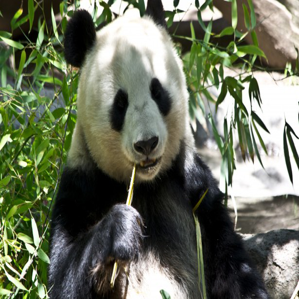

In [9]:
# Open image with PIL.Image
initial_image = Image.open("panda.jpg")

# Resize image
initial_image = initial_image.resize((299, 299))

# Jupyer supports drawing of PIL.Image if it`s a last row of a cell 
initial_image

## Prediction on image

In [10]:
# Transform PIL.Image to normalized PyTorch tensor 
normalized_image = transform(initial_image)

# Add 1 extra dimention to the start of the image.
# That`s useful when network want us to send images in bathes
# [3, 299, 299] -> [1, 3, 299, 299]
normalized_image = normalized_image.unsqueeze(0)

# Move data to GPU if available
normalized_image = normalized_image.to(device)

# Do prediction
prediction = model(normalized_image)

# Select first prediction from the batch, as we predicted only on 1 image
# [1, 1000] -> [1000]
prediction = prediction[0]

# Most of the networks predict the layer before softmax so we need to manually turn it to probabilities.
probabilities = torch.softmax(prediction, -1)

# Find class with highest probability
predicted_class = prediction.argmax(-1)

# Move predicted class to numpy array on cpu. 
# That usealy required if you working with prediction outside of PyTorch infrastructure
predicted_class = predicted_class.cpu().numpy()


print(f"Predicted class {int(predicted_class)} : {imagenet_labels[int(predicted_class)]}")
print(f"Probability: {probabilities[predicted_class]:.4f}")

Predicted class 388 : giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
Probability: 0.9897


# Using FoolBox to generate adversarial

In [11]:
import foolbox
from foolbox.models import PyTorchModel
from foolbox.attacks import L2BasicIterativeAttack
from foolbox.criteria import Misclassification, ConfidentMisclassification, TargetClassProbability

## First of all we need to wrap the model

Here ypou need to provide PyTorch model, 

acceptable bounds for the image (as it normalized image, we just puts -4, 4),

number of classes and

axis that used for storing chanels. It is 1 for PyTorch and 3 for Keras and TensorFlow.

In [12]:
fb_model = PyTorchModel(
    model, 
    bounds=(-4, +4), 
    num_classes=1000,
    channel_axis=1,
)

## Next we need to specify the target

Here we say that we want our adversarial to be recognized as class `999` with `probability > 95%`

In [13]:
criterion = TargetClassProbability(999, 0.95)

## Than we need to declare what kind of attack algorithm we want to use

Full list are available here:

https://foolbox.readthedocs.io/en/latest/modules/attacks.html

In [14]:
attack = L2BasicIterativeAttack(
    model=fb_model,
    criterion=criterion
)

# Lets Attack

In [15]:
# First we need to move our input from torch to numpy array, as it required by FoolBox
normalazed_input_numpy = normalized_image.cpu().numpy()

# Than we need to do a little modification to the predicted class
# Namely move it to array of shape [batch_size], in our case [1]
predicted_labels = np.array([int(predicted_class)])

In [16]:
# And finaly we can generate new image provided starting point and true label
new_images = attack(normalazed_input_numpy, labels=predicted_labels)

And so, we have an adversarial

## Restore normalized image

As FoolBox generates us image from the same data that model use for prediction - generated adversarial are normalized.

We need to denormalize it and move to the PIL.Image.

In [17]:
def restore_image(image):
    # Move chanel axis [3, 299, 299] -> [299, 299, 3]
    new_image = np.rollaxis(np.rollaxis((image), 2), 2)
    
    # Multiply by std and add mean
    new_image = (new_image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    
    # Move from range 0-1 to the range 0-255
    new_image = new_image * 255
    
    # Make sure to remove all values that lower that 0 or higher than 255
    # as it not valid images
    new_image = np.clip(new_image, 0, 255)
    
    # Put image to the "byte" format. 
    # That`s required by PIL.Image to be abble to restore image from numpy array
    new_image = new_image.astype(np.uint8)
    return new_image

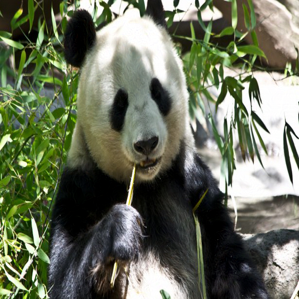

In [18]:
# Denormalize image
restored_numpy_array = restore_image(new_images[0])

# Create PIL.Image from numpy.array
restored_image = Image.fromarray(restored_numpy_array)

restored_image

## Lets check prediction on adversarial image

In [19]:
normalized_image = transform(restored_image).unsqueeze(0).to(device)
prediction = model(normalized_image)[0]
predicted_class = prediction.argmax(-1).cpu().numpy()
print(f"Predicted class {int(predicted_class)} : {imagenet_labels[int(predicted_class)]}")
print(f"Probability: {torch.softmax(prediction, -1)[predicted_class]:.4f}")

Predicted class 999 : toilet tissue, toilet paper, bathroom tissue
Probability: 0.9380


# Make lifes easier

To make our lifes easier, lest combine code for prediction and adversarial generation to the few functions

In [20]:
def generate_adversarial(foolbox_model, attack, selected_criterion, image):
    attack = attack(
        model=foolbox_model,
        criterion=selected_criterion
    )
    normalized_image = transform(image).unsqueeze(0).to(device)
    prediction = model(normalized_image)[0]
    predicted_class = prediction.argmax(-1).cpu().numpy()
    
    normalazed_input_numpy = normalized_image.cpu().numpy()
    predicted_labels = np.array([int(predicted_class)])

    new_images = attack(normalazed_input_numpy, labels=predicted_labels)
    
    restored_numpy_array = restore_image(new_images[0])
    restored_image = Image.fromarray(restored_numpy_array)
    return restored_image

In [21]:
def print_prediction(image):
    normalized_image = transform(image).unsqueeze(0).to(device)
    prediction = model(normalized_image)[0]
    predicted_class = prediction.argmax(-1).cpu().numpy()
    print(f"Predicted class {int(predicted_class)} : {imagenet_labels[int(predicted_class)]}")
    print(f"Probability: {torch.softmax(prediction, -1)[predicted_class]:.3f}")

### Lets check adversarial generation with few more classes and criteria

Predicted class 17 : jay
Probability: 0.920


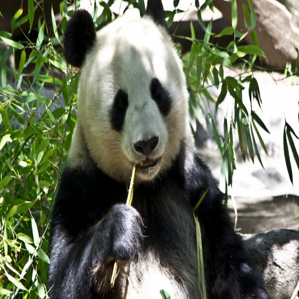

In [22]:
adv_image = generate_adversarial(
    fb_model, 
    L2BasicIterativeAttack,
    TargetClassProbability(17, 0.95), 
    initial_image
)
print_prediction(adv_image)
adv_image

Predicted class 666 : mortar
Probability: 0.921


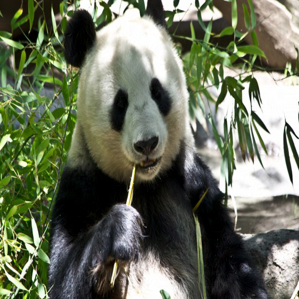

In [23]:
adv_image = generate_adversarial(
    fb_model, 
    L2BasicIterativeAttack,
    TargetClassProbability(666, 0.95), 
    initial_image
)
print_prediction(adv_image)
adv_image

Predicted class 369 : siamang, Hylobates syndactylus, Symphalangus syndactylus
Probability: 0.249


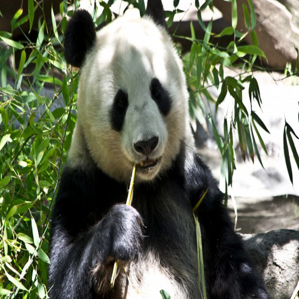

In [24]:
# Here we not targeting particular class, but want just to change the true prediction to any other
adv_image = generate_adversarial(
    fb_model, 
    L2BasicIterativeAttack,
    Misclassification(), 
    initial_image
)
print_prediction(adv_image)
adv_image

## Lets visualize adversarial perturbation 

In [25]:
# Calculate the difference between initial and aversarial images
diff = np.array(adv_image).astype(int) - np.array(initial_image).astype(int)

# Find all pixels where changes was done
diff_location = diff.mean(-1) != 0

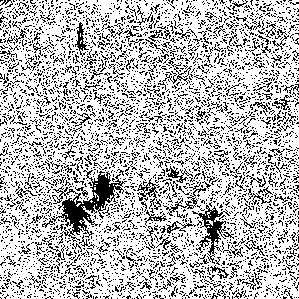

In [26]:
# White - pixels where the was some pertirbations
Image.fromarray((diff_location*255).astype(np.uint8))

In [27]:
# Lets plot colored perturbation
# For this we need to rescale all perturbations in the diapason 0-255
scaled_diff = diff - diff.min()
scaled_diff = scaled_diff / scaled_diff.max()

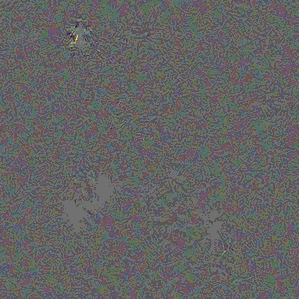

In [28]:
# Scaled difference between initial and adversarial image
Image.fromarray((scaled_diff*255).astype(np.uint8))

## Perturbation size

Here you can see how 3 common metrics used to compare size of adversaroal perturbation

L-1 norm - mean absolute difference

L-2 norm - mean square difference

L-infinity norm - maximum difference over all pixels

In [29]:
diff = np.array(adv_image).astype(int) - np.array(initial_image).astype(int)

L1_norm = np.abs(diff).mean()
L2_norm = np.sqrt((diff**2).mean())
Linfinity_norm = np.abs(diff).max()

In [30]:
print(f"L1 norm: {L1_norm}, L2 norm: {L2_norm}, L-infinity norm: {Linfinity_norm}")

L1 norm: 0.48883494964635, L2 norm: 0.7013503655686998, L-infinity norm: 5


## lets plot perturbation size with respect to target class probability

In [31]:
L1_norms = []
L2_norms = []
Linf_norms = []

for target_probabiliry in np.linspace(0.01, 0.99, 20):
    adv_image = generate_adversarial(
        fb_model, 
        L2BasicIterativeAttack,
        TargetClassProbability(666, target_probabiliry), 
        initial_image
    )
    
    diff = np.array(adv_image).astype(int) - np.array(initial_image).astype(int)
    
    L1_norms.append(np.abs(diff).mean())
    L2_norms.append(np.sqrt((diff**2).mean()))
    Linf_norms.append(np.abs(diff).max())

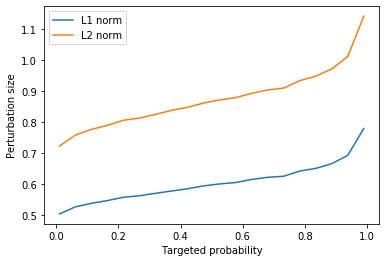

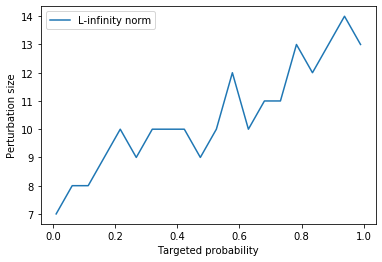

In [32]:
plt.plot(np.linspace(0.01, 0.99, 20), L1_norms, label="L1 norm")
plt.plot(np.linspace(0.01, 0.99, 20), L2_norms, label="L2 norm")
plt.legend()
plt.xlabel("Targeted probability")
plt.ylabel("Perturbation size")
plt.show()

plt.plot(np.linspace(0.01, 0.99, 20), Linf_norms, label="L-infinity norm")
plt.legend()
plt.xlabel("Targeted probability")
plt.ylabel("Perturbation size")
plt.show()

Here we can see that with increase of target class probability, both L1, L2 and L-infinity metrics grows.

You can conclude that it's harder to generate adversarial with higher probability.

# Task

1 - Do adversatial attack on pretrained ResNet-50

2 - Compare required L-1, L-2 and L-infinity norms between attacks on ResNet-50 and ResNet-18. Are there any differences? 

3 - Try new attacks. Use attacks from foolbox: PGD, AdamPGD, DeepFoolAttack or any other. Find attack with lowest L-1 for the `Misclassification()` and `TargetClassProbability(666, 0.99)`. Not all of attacks will work in all cases, so dont panic, and just put marks about it.